In [23]:
import numpy as np
import pandas as pd
import AgentClass
import const
import random
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities

ModuleNotFoundError: No module named 'AgentClass'

In [2]:
def get_tau_distr():
    lower = 0
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [3]:
def create_environment():
    list_agents = []
    tau_distr = get_tau_distr()

    for i in range(num_agents):
        in_state = np.random.randint(2, size=number_of_bits).tolist()
        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.newman_watts_strogatz_graph(num_agents, 5, 0.5, seed= 0)
#    nx.draw(G, with_labels=True, font_weight='bold') # to draw agents
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents

In [4]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [5]:
def run_simulation(alpha, const:const.Constants, list_agents, end_time):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, const.coh_transition_matrix, const.bit_matrix)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Name':agt.name,
                   'Agent_Dissonance':np.array(agt.dissonance_lst),
                   'Time':t,
                   'probs':agt.next_state_probs,
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Next_Knowledge_State':agt.next_state}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1
#         if generations%10 == 0:
#             print("alpha = {}; {} generations".format(alpha,generations))

    return pd.DataFrame(d)

In [6]:
 # constants intialization
end_simulation_time = 1000
alphas = [0.7]
exp_times = 1

# first create environment
agents_list = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)

results = {}

# for saving
agent_network_df.to_json('test_network.json',orient='records', lines=True)

for i in range(exp_times):

    random.seed(i)
    results['seed'] = i

    constants = const.Constants()

    results['coherence_matrix'] = coherence_matrix = constants.get_coh_tx_matrix().tolist()


    results['alphas'] = defaultdict(list)

    # run simulation
    for alpha in alphas:
#            record_df = pd.DataFrame({'Agent_Name':[], 'Agent_Dissonance':[], 'Time':[], 'Current_Knowledge_State':[], 'Next_Knowledge_State':[]})

        record_df = run_simulation(alpha, constants, agents_list, end_simulation_time)
#         results['alphas'][alpha].append(record_df.to_json(orient='records', lines=True))

In [7]:
knowledge_states = record_df['Current_Knowledge_State'].tolist()
int_knowledge_vals = np.array([utilities.bool2int(i) for i in knowledge_states])
K = np.zeros((len(int_knowledge_vals), 2**number_of_bits))
K[np.arange(len(int_knowledge_vals)), int_knowledge_vals] = 1


next_states = record_df['Next_Knowledge_State'].tolist()
int_nextstates_vals = np.array([utilities.bool2int(i) for i in next_states])
N = np.zeros((len(int_nextstates_vals), 2**number_of_bits))
N[np.arange(len(int_nextstates_vals)), int_nextstates_vals] = 1

soc_probs = record_df['probs'].tolist()


In [8]:
len(int_nextstates_vals)

20000

In [9]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json

matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 20

# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 500

In [10]:
import seaborn as sns

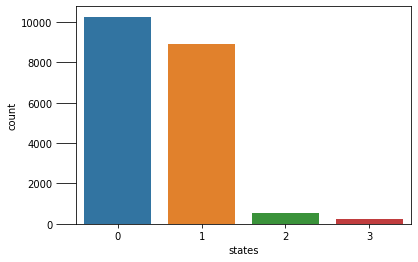

In [11]:
tmp_dataframe = pd.DataFrame(int_nextstates_vals)
tmp_dataframe.columns = ['states']
sns.countplot(x='states', data=tmp_dataframe)

In [12]:
import theano as T
import theano.tensor as tt

In [13]:
# alphas = np.array([1, 1, 1])

In [17]:
with pm.Model() as model:
    # Create the alpha and beta parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=1.0)
    alpha = pm.Uniform('alpha', 0, 1)

    meta = pm.Dirichlet('meta', np.ones((2**number_of_bits, 2**number_of_bits)), shape=(2**number_of_bits, 2**number_of_bits))

    
    # Need to fix the output_fun
    output_fun =  alpha * np.array(soc_probs) + (1-alpha) * T.dot(K, meta)
    tmp = output_fun.argmax(axis=1)
    tt.printing.Print('output_fun')(output_fun.shape)
    tt.printing.Print('tmp')(tmp.shape)
    
    p = pm.Deterministic('p', tmp)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Create the bernoulli parameter which uses the observed dat
    observed = pm.Normal('obs', sd=sigma, mu=p, observed=int_nextstates_vals)
    
    # Hamiltonian MCMC with No U-Turn Sampler

    # Sample from the posterior using the sampling method
    trace = pm.sample(N_SAMPLES, njobs=1, tune=100);

output_fun __str__ = [20000     4]
tmp __str__ = [20000]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, meta, alpha]
100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [05:47<00:00,  1.60it/s]
The acceptance probability does not match the target. It is 0.7198909984236362, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7085743252496449, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [18]:
tt.printing.Print('tmp')(tmp[500:510])

tmp __str__ = [0 1 1 1 1 0 1 0 0 0]


Print{message='tmp', attrs=('__str__',), global_fn=<function _print_fn at 0x000002315FCBA168>}.0

In [1]:
int_nextstates_vals[500:510]

NameError: name 'int_nextstates_vals' is not defined

In [29]:
trace['alpha'][100:].mean()

0.5458978599548315

In [28]:
trace['meta'][100:].mean(axis=0)

array([[0.21175123, 0.34195696, 0.26728912, 0.17900269],
       [0.27936777, 0.16949744, 0.27716835, 0.27396645],
       [0.24421428, 0.25812373, 0.18346122, 0.31420077],
       [0.38440294, 0.11933941, 0.20571457, 0.29054308]])

In [30]:
coherence_matrix

[[0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0]]